## Importing Libraries

In [139]:
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import seaborn as sns 
import datetime as dt
from collections import Counter
from nltk.tokenize import sent_tokenize
from nltk.tokenize import TweetTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

In [62]:
df = pd.read_csv(r'C:\Users\ROSHAN\Documents\GitHub\extracting-tweets-forecasting-the-upcoming-elections-in-the-us\New Extraction\Data\Biden_No_Retweet_Full_Text.csv',error_bad_lines=False)

In [63]:
df.head()

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
0,2020-07-21 23:59:43,1285726179907993601,False,@JoeBiden VP Biden I wish you wouldn't debate ...,BballmomEjZay,United States,Twitter for Android,0,54,192,0
1,2020-07-21 23:59:27,1285726110513344520,False,"#GeorgeWill , it’s so sad you wake up everyday...",TalbotMac,"East Aurora, NY",Twitter for iPhone,0,882,1554,0
2,2020-07-21 23:59:24,1285726099239055361,False,Question:\nIf @JoeBiden doesn’t pick a woman o...,bk_middleclass,"Nashville, TN",Twitter for iPhone,0,1294,1213,0
3,2020-07-21 23:58:47,1285725945849151490,False,Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...,MMorganBlair,United States,Twitter for iPhone,1,2476,3334,1
4,2020-07-21 23:58:02,1285725754961965056,False,These idiots let Trump do anything he wants. W...,realfacade1,Purgatory,Twitter for Android,0,2764,3799,0


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15098 entries, 0 to 15097
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Date       15098 non-null  object
 1   Tweet_id   15098 non-null  int64 
 2   Verified   15098 non-null  bool  
 3   Tweet      15098 non-null  object
 4   User       15098 non-null  object
 5   Location   11032 non-null  object
 6   Source     15098 non-null  object
 7   Likes      15098 non-null  int64 
 8   Followers  15098 non-null  int64 
 9   Following  15098 non-null  int64 
 10  Retweets   15098 non-null  int64 
dtypes: bool(1), int64(5), object(5)
memory usage: 1.2+ MB


In [65]:
df.shape

(15098, 11)

# Data Preprocessing & Cleaning

In [66]:
df['Date'] = df['Date'].apply(lambda x: dt.datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) #Convert to date time format

In [67]:
df.dtypes

Date         datetime64[ns]
Tweet_id              int64
Verified               bool
Tweet                object
User                 object
Location             object
Source               object
Likes                 int64
Followers             int64
Following             int64
Retweets              int64
dtype: object

In [68]:
df.isnull().sum()

Date            0
Tweet_id        0
Verified        0
Tweet           0
User            0
Location     4066
Source          0
Likes           0
Followers       0
Following       0
Retweets        0
dtype: int64

In [69]:
df['Source'].value_counts()

Twitter Web App        5910
Twitter for iPhone     4565
Twitter for Android    3267
Twitter for iPad        705
TweetDeck               150
                       ... 
Bitly                     1
Socialbakers              1
PoliTweetBot              1
Article Tweetbot          1
UNIAN Info                1
Name: Source, Length: 87, dtype: int64

In [70]:
df['Location'].nunique()

3200

In [71]:
tweets_list = df['Tweet'].tolist()
len(tweets_list)

15098

In [72]:
tweets_list_updated = set(tweets_list)
len(tweets_list_updated)

15046

In [73]:
tweets_list_updated  = list(tweets_list_updated)
type(tweets_list_updated)

list

In [74]:
df['Tweet'].duplicated().sum()

52

In [75]:
df = df.drop_duplicates(subset = 'Tweet', keep = 'first',ignore_index = True)
df.shape

(15046, 11)

Removed all the duplicates

In [76]:
df['Tweet'].duplicated().sum()

0

### Remove emojis

In [77]:
def remove_emoji(tweet):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', tweet)



df.Tweet=df.Tweet.apply(remove_emoji)


In [78]:
df['Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Tweet, Length: 15046, dtype: object

In [79]:
count = 0
for i in df['Tweet']:
    if re.match(r'^RT', i):  #remove any rows that contain RT
        df.drop(df.loc[df['Tweet']==i].index,inplace = True)
        count+=1
    
count

0

In [80]:
df.shape

(15046, 11)

In [81]:
df['Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Tweet, Length: 15046, dtype: object

### Remove RT 

In [82]:
df['Tweet'] = [re.sub('^RT[\s]','',i) for i in df['Tweet']]  #Remove RT substring

In [83]:
df['Tweet']

0        @JoeBiden VP Biden I wish you wouldn't debate ...
1        #GeorgeWill , it’s so sad you wake up everyday...
2        Question:\nIf @JoeBiden doesn’t pick a woman o...
3        Right? 🤣🤣🤣 #Biden formally implicated in #Ukra...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing #StromThurm...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about #Biden maybe activating res...
15044    Fake #Polls? Why #Biden's 'Nationwide Lead' Ov...
15045    #Joe #Biden #Trump police should not be armed ...
Name: Tweet, Length: 15046, dtype: object

In [84]:
import preprocessor as p #Module for faster preprocessing specifically for tweets

In [85]:
df['Tweet'] = [p.clean(i) for i in df['Tweet']]

In [86]:
df['Tweet']

0        VP Biden I wish you wouldn't debate Trump unle...
1        , its so sad you wake up everyday forgetting t...
2        Question:If doesnt pick a woman of color, woul...
3        Right? formally implicated in scandal reported...
4        These idiots let Trump do anything he wants. W...
                               ...                        
15041    Other than going big by eulogizing (how does t...
15042    Don't want to leave out the left! Show your su...
15043    Some chatter about maybe activating resources ...
15044    Fake ? Why 's 'Nationwide Lead' Over Says Noth...
15045             police should not be armed to the teeth.
Name: Tweet, Length: 15046, dtype: object

In [87]:
#removing unnecessary special characters, numbers, punctuations in tweets
df.Tweet = df.Tweet.str.replace("[^a-zA-Z]", " ")


In [88]:
df["Tweet"]

0        VP Biden I wish you wouldn t debate Trump unle...
1          its so sad you wake up everyday forgetting t...
2        Question If doesnt pick a woman of color  woul...
3        Right  formally implicated in scandal reported...
4        These idiots let Trump do anything he wants  W...
                               ...                        
15041    Other than going big by eulogizing  how does t...
15042    Don t want to leave out the left  Show your su...
15043    Some chatter about maybe activating resources ...
15044    Fake   Why  s  Nationwide Lead  Over Says Noth...
15045             police should not be armed to the teeth 
Name: Tweet, Length: 15046, dtype: object

In [89]:
df.Tweet = [low.lower() for low in df.Tweet] #Converting into lower case 

In [90]:
df["Tweet"]

0        vp biden i wish you wouldn t debate trump unle...
1          its so sad you wake up everyday forgetting t...
2        question if doesnt pick a woman of color  woul...
3        right  formally implicated in scandal reported...
4        these idiots let trump do anything he wants  w...
                               ...                        
15041    other than going big by eulogizing  how does t...
15042    don t want to leave out the left  show your su...
15043    some chatter about maybe activating resources ...
15044    fake   why  s  nationwide lead  over says noth...
15045             police should not be armed to the teeth 
Name: Tweet, Length: 15046, dtype: object

In [91]:
df['Tweet'][12] #Sample tweet

'took know questions so he could tell you know lies  of course the lies would make absolutely no sense because he has no idea where he is or what hes doing  twit '

# EDA

In [133]:
df['User'].value_counts()

Hotpage_News       544
jacketrose86       174
mobygrapefan        71
defeatthedevil      67
deepen915           61
                  ... 
Alicia_S_Ox          1
ResourcesAmy         1
joelcan              1
rockenschtroodl      1
MikeBoring           1
Name: User, Length: 8270, dtype: int64

A whopping 544 tweets from Hotpage_News. This seems to be an account owned by an organization. Let us have a look at jacketrose86.

In [135]:
df.query('User == "jacketrose86"').Tweet.tolist()

['the can be no order when the laws remain unjust  trump s tyranny runs rampant while we die by the thousands   vote joe   liar  liar pants on fire  you re on the wrong side i d history  fk',
 'it is our duty to protect the world from trump  we can t let him win another term ',
 'there are more reasons to not vote for him  staying alive is one of them  biden cares if we live or die   fk',
 'aww thanks for adding me fk',
 'thanks so much   have some snacks for cocktail hour  they re about the same size as his cocktail fk',
 'nobody lives him not even his wife  fk that guy right hin his stupid face   fk',
 'you tell em bro  thanks for the mention you rock   fk',
 'too little too late   y all have massive amounts of blood on your hands   fk',
 'this one   he wants us all to die   fk',
 'shame on all of them   vote joe to save america   fk',
 'hey he s my least favorite president too  fk',
 'thank you so much cris   let s put the pressure on and be loud   fk',
 'thanks king more to     com

A manual inspection clearly indicates a negative sentiment towards the candidature of Joe Biden

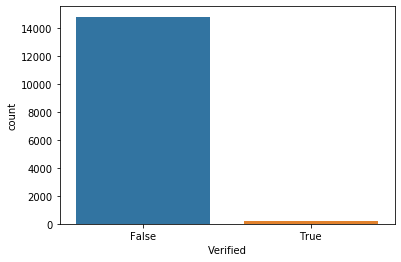

In [93]:
bar = sns.countplot(df['Verified'])

In [94]:
df['Verified'].value_counts()

False    14830
True       216
Name: Verified, dtype: int64

Only 216 verified accounts were extracted. This shouldn't be a problem while calculating our sentiment.

In [95]:
df_verified = df.query('Verified == True')
df_verified 

,Date,Tweet_id,Verified,Tweet,User,Location,Source,Likes,Followers,Following,Retweets
116,2020-07-21 23:00:01,1285711153465683971,True,judicial watch announced it received records f...,JudicialWatch,"Washington, DC",TweetDeck,552,1738234,1924,327
186,2020-07-21 22:21:56,1285701570932477952,True,stay tuned folks,IamJohnBurnett,"New York, NY",Twitter Web App,3,15341,3102,1
205,2020-07-21 22:14:26,1285699685982838786,True,can overcome s lead in the polls ask the exp...,IamJohnBurnett,"New York, NY",Twitter Web App,5,15341,3102,1
228,2020-07-21 22:05:17,1285697381275709441,True,support open edition or limited edition prin...,annawilding,United States,Twitter Web App,2,1706,2015,0
316,2020-07-21 21:15:04,1285684742617206784,True,comment though talks about ending endless ...,The_NewArab,London,Hootsuite Inc.,2,88631,228,1
...,...,...,...,...,...,...,...,...,...,...,...
14801,2020-07-13 14:58:33,1282690889668755458,True,the latest poll shows joe with a significant l...,Varneyco,New York,Twitter Web App,109,658176,729,41
14913,2020-07-13 13:26:50,1282667808279670785,True,arctic at record ice melts devastating ...,DemsAbroad,Worldwide!,Twitter for iPhone,3,18747,8730,0
15005,2020-07-13 11:52:52,1282644156859518976,True,yes it is because is not an ignorant incomp...,AndyOstroy,NYC,Twitter for iPhone,421,78928,3202,46
15031,2020-07-13 11:25:41,1282637319783284736,True,hey resign while you can before youre dealt...,AndyOstroy,NYC,Twitter for iPhone,123,78928,3202,37


In [96]:
df_verified['User'].value_counts()

AndyOstroy       15
JudicialWatch     9
The_NewArab       7
DemsAbroad        7
Varneyco          7
                 ..
annawilding       1
garrett_geoff     1
RiceUNews         1
PredictIt         1
NH_India          1
Name: User, Length: 121, dtype: int64

A user by the name AndyOstroy has 15 tweets about Joe Biden in the time-period of extraction. Let us look at some of his tweets.

In [97]:
df_verified.query('User == "AndyOstroy"').Tweet.tolist()

['its intellectually dishonest  and quite hypocritical  for liberals who preach unity and bipartisanship to be losing their damn minds because one republican is gonna speak at the democratic convention   ',
 'we are now at a new cray cray low in the presidency where he s challenged to a duel to see who can  ace  the  is this a lion or a monkey   cognitive test   ',
 'humiliating   historic    landslide  its coming    ',
 'hey    kinda like how you cried daddy  daddy  please dont let them make me go to vietnam  before he bought you those deferments  coward   ',
 'how do you feel about as  s vp ',
 'i believe on nov rd were going to witness the biggest  most humiliating  most historic backlash against and republicans this country has ever seen and could ever have imagined   ',
 'hey moron   all of this darkness  despair  dysfunction  disease  death you re showing here happened on your watch  great ad for     ',
 'kudos   manbaby just hates being caught in his pathetic lies   ',
 'hey    

He seems to be very angry towards Joe Biden & clearly has no positive sentiment 

Let us look at another, JudicialWatch

In [98]:
df_verified.query('User == "JudicialWatch"').Tweet.tolist()

['judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the administration  hunter traveled extensively while receiving a secret service protective detail  read ',
 '  president    theres no lawful reason for the university of delaware to withhold records  read more at',
 ' judicial watch investigators uncovered records from the u s  secret service showing that  for the first and a half years of the obama admin  hunter traveled extensively with a secret service protective detail  in newsmax  read ',
 'judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the administration  hunter traveled extensively while receiving a secret service protective detail  read ',
 'judicial watch announced it received records from the u s  secret service showing that  for the and a half years of the administration  hunter traveled extensively while receiving a secret service protecti

On manual inspection, there seems to be sentiment towards Joe Biden. Can be classified as a Neutral user.

Let us observe the dates & how they fair out. Let us observe how many tweets were extracted on which date

In [110]:
days = df['Date'].dt.day.tolist()

In [121]:
no_of_days = Counter(days)
no_of_days

Counter({21: 2084,
         20: 1862,
         19: 1712,
         18: 1322,
         17: 1573,
         16: 1638,
         15: 2020,
         14: 1884,
         13: 951})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Day')

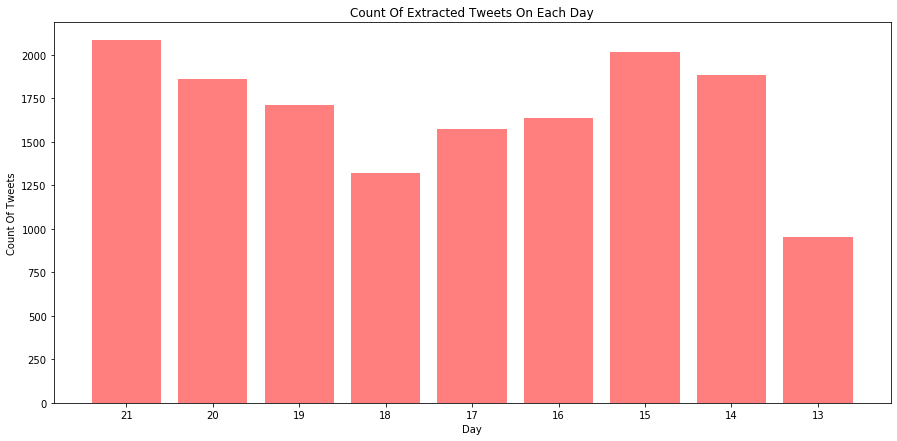

In [130]:
fig = plt.figure(figsize = (15,7))
plt.bar(range(len(no_of_days)), list(no_of_days.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_days)), list(no_of_days.keys()))
plt.xlabel("Day")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Day")

We had a maximum of approx 2000 tweets extracted on the 21st July & the 15th of July.

Let us also look at the times (hours) at which the most tweets were extracted.

In [118]:
hours = df['Date'].dt.hour.tolist()

In [123]:
no_of_hours = Counter(hours)
no_of_hours

Counter({23: 857,
         22: 917,
         21: 891,
         20: 829,
         19: 828,
         18: 1107,
         17: 938,
         16: 953,
         15: 867,
         14: 834,
         13: 740,
         12: 560,
         11: 423,
         10: 260,
         9: 156,
         8: 157,
         7: 198,
         6: 237,
         5: 290,
         4: 397,
         3: 475,
         2: 628,
         1: 780,
         0: 724})

Text(0.5, 1.0, 'Count Of Extracted Tweets On Each Hour')

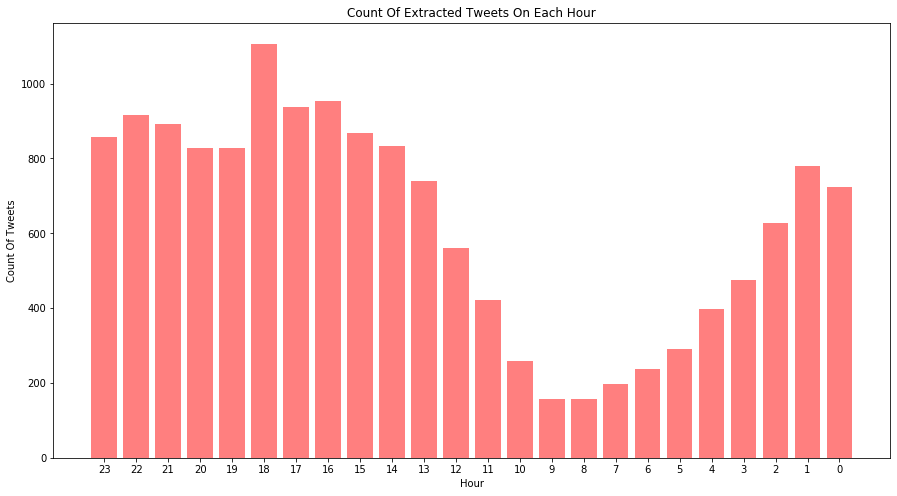

In [131]:
fig = plt.figure(figsize = (15,8))
plt.bar(range(len(no_of_hours)), list(no_of_hours.values()), align='center', alpha = 0.5,color = 'red')
plt.xticks(range(len(no_of_hours)), list(no_of_hours.keys()))
plt.xlabel("Hour")
plt.ylabel("Count Of Tweets")
plt.title("Count Of Extracted Tweets On Each Hour")

Lots of tweets at the 18:00 - 19:00 hour period followed by 16:00 - 17:00 hour

In [137]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [138]:
from wordcloud import WordCloud


In [147]:
tokenizer = TweetTokenizer()
texts = []
text = []
texts = df.Tweet.apply(lambda x:tokenizer.tokenize(x))

In [148]:
for i in texts:
    for j in i:
        text.append(j)

In [150]:
len(text)

320478

So after tokenizing, a total of 3,20,478 words are going to be used for our model.

In [153]:
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(' '.join(text))

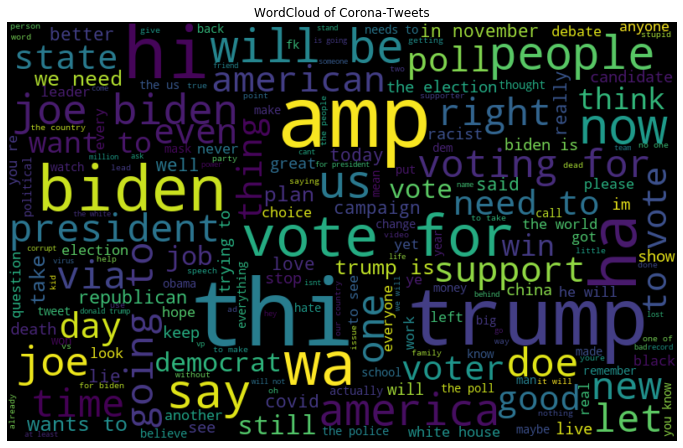

In [154]:
plt.figure(figsize = (12, 12), facecolor="None") 
plt.imshow(wordcloud,interpolation='bilinear') 
plt.axis("off") 
plt.title("WordCloud of Corona-Tweets")
plt.show()

We still have to remove stopwords, perform lemmatization & do stemming. So let us proceed with that

### Removing Stop Words

In [155]:
stop_words = set(stopwords.words('english')) 
print(stop_words)

{'what', 'there', 'after', 'at', 'an', 'you', "mightn't", "it's", 'i', 'being', 'further', 'himself', 'over', "didn't", 'by', "mustn't", 'do', 'to', 'did', 'your', 'ours', 'against', 'my', "you'll", 'm', "you'd", 'through', 'mightn', "shan't", 'hers', "she's", 'hasn', 'it', 'both', 'but', 'on', 'into', 'themselves', 'below', 'ma', 'before', 'where', 've', 'doesn', 'of', 'y', 'yourself', 'has', "needn't", 'them', 'all', "should've", 'who', 'again', "won't", 'him', 'than', 'she', 'they', 'own', 'or', "hasn't", 'be', 'll', 'o', 'here', 'a', 'down', "you've", 'will', 'because', "weren't", "wouldn't", 'during', 'weren', 'other', "hadn't", 'some', 'the', 'until', 'ourselves', 'yours', 'any', 'which', 'itself', 'whom', 'her', 'needn', "shouldn't", 'such', 'yourselves', 'when', 'once', 'out', 'don', 'd', 'is', "aren't", 'mustn', 'been', "doesn't", 'having', 'was', 'can', 'that', 'only', "don't", 'were', 'why', 'he', 'shan', "haven't", 'between', 'no', "couldn't", 'as', 'for', 'not', 'nor', 'so

In [156]:
text = [i for i in text if not i in stop_words]

In [157]:
len(text)

173702

In [158]:
#Perform stemming & lemmatization
def lemmatize_stemming(text):
    stemmer=PorterStemmer()
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))
text = [lemmatize_stemming(i) for i in text ]

In [ ]:
#def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in STOPWORDS and len(token) > 2:
            result.append(lemmatize_stemming(token))
    return result